# 🎓 Examen Final: SQL y Gestión de Datos (15 Puntos)

**Contexto:** Eres el Data Steward de la **Universidad Santo Tomás**. Se acerca el cierre de semestre y la decanatura requiere una gestión intensiva de la base de datos: desde registrar ofertas de última hora hasta generar los indicadores finales de deserción y carga académica.

**Instrucciones:**
* Asegúrate de tener el archivo **`universidad.db`** en esta misma carpeta.
* Cada punto tiene un valor de **1.0** sobre 15.
* Usa `conn.commit()` después de las sentencias de modificación (INSERT/UPDATE/DELETE).
* Usa `pd.read_sql_query` para las consultas de selección (SELECT).

---

In [28]:
## 🛠️ CONFIGURACIÓN INICIAL 
import sqlite3
import pandas as pd
import os

db_filename = '../Datos/universidad.db'

if not os.path.exists(db_filename):
    print(f"⚠️ ERROR: No encuentro '{db_filename}'. Súbelo a esta carpeta.")
else:
    conn = sqlite3.connect(db_filename)
    cursor = conn.cursor()
    cursor.execute("PRAGMA foreign_keys = ON;")
    print(f"✅ Conectado a '{db_filename}'. ¡Listo para el examen!")

✅ Conectado a '../Datos/universidad.db'. ¡Listo para el examen!


## 📝 Sección 1: Gestión Académica (DML) - 5 Puntos

**1. Apertura de Curso (INSERT)**
La facultad abre un nuevo curso electivo.
* Inserta en la tabla `Cursos`:
    * Nombre: **'Big Data & AI'**
    * Créditos: **5**
    * ID Profesor: **20**

**2. Nuevo Ingreso (INSERT)**
Registra a un nuevo estudiante en la tabla `Estudiantes`:
    * Nombre: **'Lionel'**
    * Apellido: **'Messi'**
    * Email: **'lio@usta.edu.co'**
    * Fecha Ingreso: '2024-11-25'

**3. Matrícula Manual (INSERT)**
Matricula al estudiante 'Lionel Messi' en el curso de 'Big Data & AI' que acabas de crear.
* *Pista:* Necesitarás averiguar primero qué ID le asignó la base de datos a Lionel y al curso.
* Nota final: `NULL`.

**4. Corrección de Créditos (UPDATE)**
El comité curricular decidió que 5 créditos es demasiado.
* Actualiza el curso 'Big Data & AI' para que tenga **3 créditos**.

**5. Retiro Definitivo (DELETE)**
El estudiante con **ID = 10** se retira de la universidad.
* Elimina todos sus registros de la tabla `Inscripciones` (para mantener la integridad, primero borramos sus clases).

In [29]:
# 1. Apertura de Curso (INSERT)
query_1 = '''
INSERT INTO Cursos (nombre_curso, creditos, id_profesor)
VALUES ('Big Data & AI', 3, 20)
'''
cursor.execute(query_1)
conn.commit()
print("Punto 1: Curso 'Big Data & AI' abierto")

# 2. Nuevo Ingreso (INSERT)
query_2 = '''
INSERT INTO Estudiantes (nombre, apellido, email, fecha_ingreso)
VALUES ('Lionel', 'Messi', 'lio@usta.edu.co', '2024-11-25')
'''
# Nota: Si el estudiante ya existe, esto será ignorado o causará un error (UNIQUE constraint), 
cursor.execute(query_2)
conn.commit()
print("Punto 2: Estudiante ingresado")

# 3. Matrícula Manual (INSERT)

# PASO 1: Obtener el ID del estudiante 'Lionel Messi'
query_3_select_estudiante = '''
SELECT id_estudiante
FROM Estudiantes
WHERE nombre = 'Lionel' AND apellido = 'Messi'
'''
cursor.execute(query_3_select_estudiante)
estudiante_id = cursor.fetchone()[0] 

# PASO 2: Obtener el ID del curso 'Big Data & AI'
query_3_select_curso = '''
SELECT id_curso
FROM Cursos
WHERE nombre_curso = 'Big Data & AI'
'''
cursor.execute(query_3_select_curso)
curso_id = cursor.fetchone()[0] 

# PASO 3: Insertar la matrícula con los IDs dinámicos
query_3_insert = '''
INSERT INTO Inscripciones (id_estudiante, id_curso)
VALUES (?, ?)
'''
# Usamos el estudiante_id y el curso_id que acabamos de obtener
data = [(estudiante_id, curso_id)] 
cursor.executemany(query_3_insert, data)
conn.commit()
print("Punto 3: Estudiante matriculado exitosamente en Curso:'Big Data & AI'.")

# 4. Corrección de Créditos (UPDATE)
query_4 = '''
UPDATE Cursos
SET creditos = ?
WHERE nombre_curso = 'Big Data & AI'
'''
data_4 = [3] # Se corrige a 3 créditos
cursor.execute(query_4, data_4)
conn.commit()
print("Punto 4: Se actualizo a 3 Créditos el Curso de 'Big Data & AI'")

# 5. Retiro Definitivo (DELETE)
# Para cumplir con la restricción de FOREIGN KEY, se borra en orden.
# 5.1: Eliminar inscripciones
cursor.execute("DELETE FROM Inscripciones WHERE id_estudiante = 10")
conn.commit()
print("....Las Inscripciones del ID 10 han sido eliminadas")
# 5.2: Eliminar al estudiante
cursor.execute("DELETE FROM Estudiantes WHERE id_estudiante = 10")
conn.commit()
print(".....El Estudiante con el ID 10 ha sido eliminado")
print("Punto 5: El Estudiante Fue Retirado de la Universidad")
print("\n SECCIÓN 1 FINALIZADA")

Punto 1: Curso 'Big Data & AI' abierto
Punto 2: Estudiante ingresado
Punto 3: Estudiante matriculado exitosamente en Curso:'Big Data & AI'.
Punto 4: Se actualizo a 3 Créditos el Curso de 'Big Data & AI'
....Las Inscripciones del ID 10 han sido eliminadas
.....El Estudiante con el ID 10 ha sido eliminado
Punto 5: El Estudiante Fue Retirado de la Universidad

 SECCIÓN 1 FINALIZADA


## 🔍 Sección 2: Consultas SQL (Analysis) - 6 Puntos

**6. Métricas Generales (Agregación)**
Calcula y muestra:
* Cantidad total de estudiantes.
* Cantidad total de cursos ofertados.
* Promedio de créditos de los cursos.

**7. Auditoría de Profesores (LEFT JOIN)**
Necesitamos ver la carga laboral completa.
* Lista **todos** los profesores (Nombre y Apellido) y el curso que dictan.
* **Condición:** Deben aparecer los profesores que **NO** tienen cursos asignados actualmente (valor NULL).

**8. Popularidad (GROUP BY)**
* Genera una lista con el `Nombre del Curso` y la **Cantidad de Estudiantes** inscritos en él.
* Ordena del más popular al menos popular.

**9. Cursos Masivos (HAVING)**
* Basado en la consulta anterior, filtra para mostrar solo los cursos que tienen **más de 20 estudiantes** inscritos.

**10. Búsqueda Inteligente (Subconsulta)**
* Obtén el nombre y apellido de los estudiantes inscritos en el curso **"Bases de Datos"**.
* **Reto:** No uses el ID=1 directamente. Usa una subconsulta `(SELECT id_curso FROM Cursos WHERE nombre_curso = 'Bases de Datos')`.

**11. Sábana de Notas (INNER JOIN Múltiple)**
* Genera un reporte detallado que contenga:
    * Nombre Estudiante | Apellido Estudiante | Nombre Curso | Nota Final | Nombre Profesor

In [30]:
# 🔍 Sección 2: Consultas SQL (Analysis) - 6 Puntos

# 6. Métricas Generales (Agregación)
print("\n--- 6. Métricas Generales (Agregación) ---")

query = '''
SELECT
    (SELECT COUNT(DISTINCT id_estudiante) FROM Estudiantes) AS cantidad_total_estudiantes,
    COUNT(id_curso) AS cantidad_total_cursos,
    AVG(creditos) AS promedio_creditos
FROM Cursos;
'''

df_metrics = pd.read_sql_query(query, conn)
display(df_metrics)

# 7. Auditoría de Profesores (LEFT JOIN)
query = '''
SELECT P.nombre, P.apellido, C.nombre_curso AS nombre_curso
FROM Profesores P LEFT JOIN Cursos C ON P.id_profesor = C.id_profesor
WHERE C.id_curso IS NULL
'''
df_profesores = pd.read_sql_query(query, conn)
print("\n--- 7. Auditoría de Profesores (LEFT JOIN) ---")
print(df_profesores)

# 8. Popularidad (GROUP BY)
query = '''
SELECT C.nombre_curso AS nombre_curso, COUNT(I.id_estudiante) AS cantidad_estudiantes
FROM Cursos C JOIN Inscripciones I ON C.id_curso = I.id_curso
GROUP BY C.nombre_curso
ORDER BY cantidad_estudiantes DESC
'''
df_popularidad = pd.read_sql_query(query, conn)
print("\n--- 8. Popularidad (GROUP BY) ---")
print(df_popularidad)

# 9. Cursos Masivos (HAVING)
query = '''
SELECT C.nombre_curso AS nombre_curso, COUNT(I.id_estudiante) AS cantidad_estudiantes
FROM Cursos C JOIN Inscripciones I ON C.id_curso = I.id_curso
GROUP BY C.nombre_curso
HAVING COUNT(I.id_estudiante) > 20
'''
df_cursos_masivos = pd.read_sql_query(query, conn)
print("\n--- 9. Cursos Masivos (HAVING) ---")
print(df_cursos_masivos)

# 10. Búsqueda Inteligente (Subconsulta)
query = '''
SELECT E.nombre, E.apellido
FROM Estudiantes E JOIN Inscripciones I ON E.id_estudiante = I.id_estudiante
WHERE I.id_curso IN (
SELECT id_curso
FROM Cursos
WHERE nombre_curso = 'Bases de Datos'
        )
'''
df_busqueda_inteligente = pd.read_sql_query(query, conn)
print("\n--- 10. Búsqueda Inteligente (Subconsulta) ---")
print(df_busqueda_inteligente)

query_sabana = '''
SELECT
    e.nombre AS 'Nombre Estudiante',
    e.apellido AS 'Apellido Estudiante',
    c.nombre_curso AS 'Nombre Curso',
    i.nota_final AS 'Nota Final',
    p.nombre || ' ' || p.apellido AS 'Nombre Profesor'
FROM Inscripciones i
JOIN Estudiantes e ON i.id_estudiante = e.id_estudiante
JOIN Cursos c ON i.id_curso = c.id_curso
JOIN Profesores p ON c.id_profesor = p.id_profesor;
'''
df_notas = pd.read_sql_query(query_sabana, conn)

print("\n--- 11. Sabana de Notas Completa (DataFrame Reporte) ---")
# se usa display(df_notas) para mostrar el reporte en formato tabular
display(df_notas.head(2100))

print("\n SECCIÓN 2 FINALIZADA")



--- 6. Métricas Generales (Agregación) ---


,cantidad_total_estudiantes,cantidad_total_cursos,promedio_creditos
0,500,101,2.70297



--- 7. Auditoría de Profesores (LEFT JOIN) ---
      nombre apellido nombre_curso
0      Jorge   Romero         None
1      Lucia     Rios         None
2    Ricardo     Sosa         None
3      Mateo  Jimenez         None
4    Esteban     Sosa         None
5      David     Rios         None
6   Fernando     Ruiz         None
7   Fernando   Pineda         None
8     Camila  Jimenez         None
9      Laura   Torres         None
10   Nicolas  Jimenez         None

--- 8. Popularidad (GROUP BY) ---
         nombre_curso  cantidad_estudiantes
0   Economía Avanzado                   103
1      Ética Avanzado                    83
2      Bases de Datos                    70
3     Inglés Avanzado                    62
4          Inglés III                    61
..                ...                   ...
59  Historia Avanzado                    14
60      Estadística I                    13
61             Arte I                    13
62    Física Avanzado                    12
63      Big D

,Nombre Estudiante,Apellido Estudiante,Nombre Curso,Nota Final,Nombre Profesor
0,Esteban,Perez,Bases de Datos,3.8,Andres Rios
1,Mateo,Pineda,Bases de Datos,4.5,Andres Rios
2,Elena,Navarro,Bases de Datos,1.9,Andres Rios
3,Sofia,Mendoza,Bases de Datos,2.5,Andres Rios
4,Elena,Gutierrez,Bases de Datos,2.5,Andres Rios
...,...,...,...,...,...
2019,David,Ruiz,Inglés Avanzado,1.8,Kevin Navarro
2020,David,Ruiz,Economía Básico,2.9,Marta Maya
2021,David,Ruiz,Ética III,2.1,Andres Rios
2022,David,Ruiz,Inglés Avanzado,2.6,Camila Martinez



 SECCIÓN 2 FINALIZADA


## 📊 Sección 3: Analítica con Python (Pandas) - 4 Puntos

**12. Carga de Datos**
* Ejecuta la consulta del punto 11 (Sábana de Notas) y guárdala en un DataFrame llamado `df_notas`.
* Muestra las primeras 5 filas y usa `.info()` para verificar tipos de datos.

**13. Análisis de Riesgo**
* Filtra el DataFrame `df_notas` para encontrar a los estudiantes que van perdiendo (Nota < 3.0).
* Guárdalos en un nuevo DF `df_riesgo` y cuenta cuántos son.

**14. Tabla Pivote (Cruce de Variables)**
* Crea una tabla dinámica que muestre el **Promedio de Notas** (values) organizados por `Nombre Curso` (index) y `Nombre Profesor` (columns).

**15. Visualización (Gráfico)**
* Usando el DataFrame `df_notas`, crea un histograma o un gráfico de barras que muestre la distribución de las notas finales.
* *Opcional:* Un gráfico de barras con el Top 5 de cursos con más estudiantes.

--- 12. Carga de Datos: DataFrame df_notas ---


,Nombre Estudiante,Apellido Estudiante,Nombre Curso,Nota Final,Nombre Profesor
0,Esteban,Perez,Bases de Datos,3.8,Andres Rios
1,Mateo,Pineda,Bases de Datos,4.5,Andres Rios
2,Elena,Navarro,Bases de Datos,1.9,Andres Rios
3,Sofia,Mendoza,Bases de Datos,2.5,Andres Rios
4,Elena,Gutierrez,Bases de Datos,2.5,Andres Rios



Información del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2024 entries, 0 to 2023
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Nombre Estudiante    2024 non-null   object 
 1   Apellido Estudiante  2024 non-null   object 
 2   Nombre Curso         2024 non-null   object 
 3   Nota Final           2023 non-null   float64
 4   Nombre Profesor      2024 non-null   object 
dtypes: float64(1), object(4)
memory usage: 79.2+ KB

--- 13. Análisis de Riesgo: Estudiantes en Riesgo (Nota < 3.0) ---
Cantidad de estudiantes perdiendo: 847

--- 14. Tabla Pivote: Promedio por Curso y Profesor ---


Nombre Profesor,Ana Diaz,Ana Jimenez,Andres Navarro,Andres Rios,Beatriz Torres,Beatriz Zainea,Camila Martinez,Daniela Gutierrez,David Mora,David Silva,...,Nicolas Mendoza,Nicolas Ortega,Oscar Cardenas,Paula Castillo,Ricardo Perez,Valentina Diaz,Valentina Lopez,Valeria Maya,Valeria Pineda,Valeria Zainea
Nombre Curso,,,,,,,,,,,,,,,,,,,,,
Arte Aplicado,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Arte Avanzado,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Arte General,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Arte I,NaN,NaN,NaN,2.969231,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Arte II,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.2,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Álgebra Básico,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.066667
Álgebra General,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.323333
Ética Avanzado,NaN,NaN,NaN,NaN,3.4625,NaN,NaN,NaN,NaN,NaN,...,NaN,3.031707,NaN,NaN,NaN,NaN,NaN,3.894444,NaN,NaN



--- 15. Visualización (Gráfico): Distribución de Notas ---


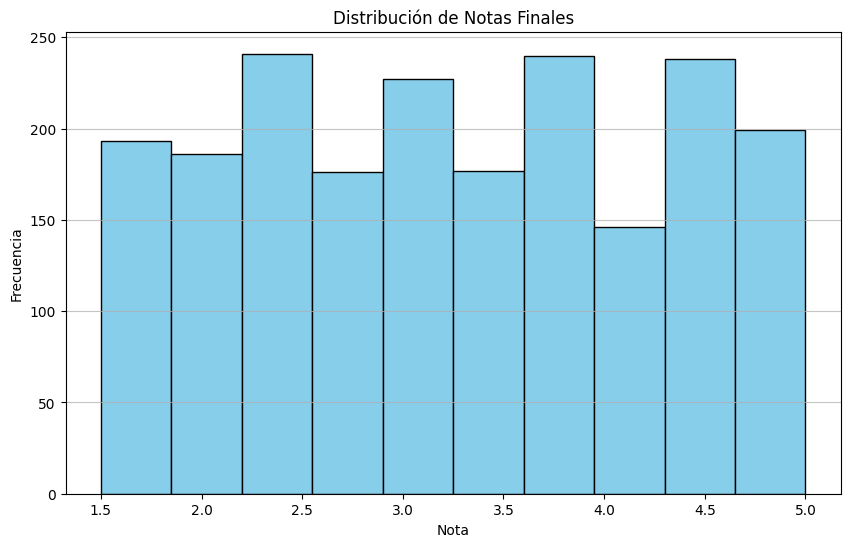


--- Top 5 Cursos con más estudiantes (Tabla) ---


Nombre Curso
Economía Avanzado    103
Ética Avanzado        83
Bases de Datos        70
Inglés Avanzado       62
Inglés III            61
Name: count, dtype: int64

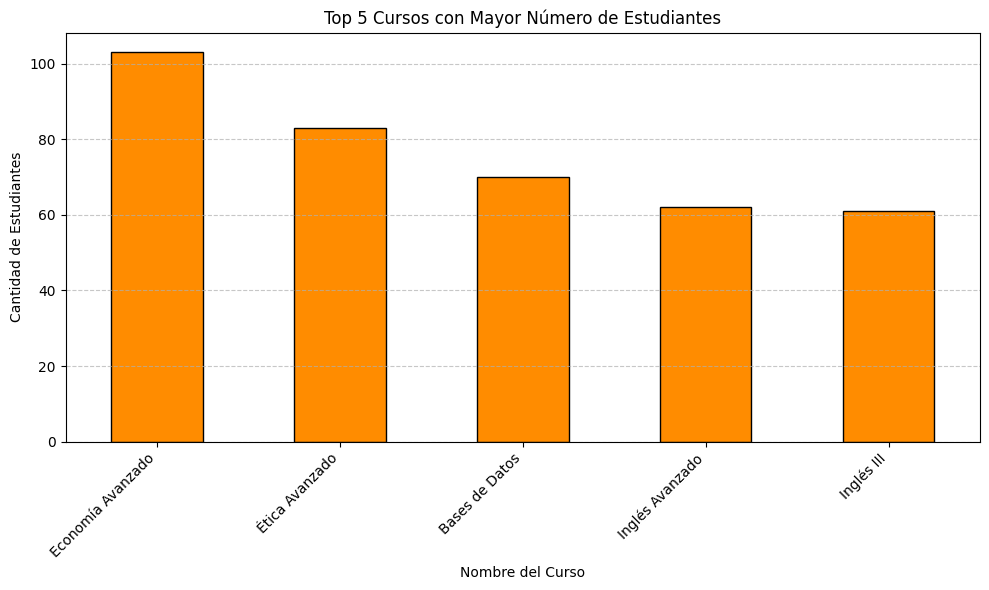

¡Examen Finalizado!


In [31]:
import pandas as pd
import matplotlib.pyplot as plt

# --- 12. Carga de Datos ---
print("--- 12. Carga de Datos: DataFrame df_notas ---")
# Se usa pd.read_sql_query para crear el DataFrame, esto convierte el resultado SQL del punto 11 en una tabla de reporte (DataFrame) automáticamente
df_notas = pd.read_sql_query(query_sabana, conn)

display(df_notas.head())
print("\nInformación del DataFrame:")
df_notas.info()

# --- 13. Análisis de Riesgo ---
print("\n--- 13. Análisis de Riesgo: Estudiantes en Riesgo (Nota < 3.0) ---")
# Usamos .copy() para evitar advertencias de pandas
df_riesgo = df_notas[df_notas['Nota Final'] < 3.0].copy()
cantidad_riesgo = len(df_riesgo)

print(f"Cantidad de estudiantes perdiendo: {cantidad_riesgo}")

# --- 14. Tabla Pivote: Promedio por Curso y Profesor (COMPLETO) ---
print("\n--- 14. Tabla Pivote: Promedio por Curso y Profesor ---")
# Conversión de Tipo de Dato:  Se usa pd.to_numeric para asegurar que la columna Nota Final sea un número (float)
# errors='coerce' reemplaza cualquier valor no numérico (como textos o símbolos) con NaN
df_notas['Nota Final'] = pd.to_numeric(df_notas['Nota Final'], errors='coerce')

# método .pivot_table() sobre el DataFrame df_notas
pivot_table = df_notas.pivot_table(
    # 'index' (Nombre Curso)
    index='Nombre Curso',
    # 'columns' (Nombre Profesor)
    columns='Nombre Profesor',
    # 'values'  (Nota Final)
    values='Nota Final',
    # 'aggfunc' (función de agregación promedio)
    aggfunc='mean'
)
# Mostrar la tabla pivote
display(pivot_table)


# --- 15. Visualización (Gráfico): Distribución de Notas ---
print("\n--- 15. Visualización (Gráfico): Distribución de Notas ---")
# Aseguramos que la columna sea numérica (para evitar errores en la visualización)
df_notas['Nota Final'] = pd.to_numeric(df_notas['Nota Final'], errors='coerce')


plt.figure(figsize=(10, 6))
# .dropna() elimina los NaN generados por la conversión si hubiera texto.
plt.hist(df_notas['Nota Final'].dropna(), bins=10, color='skyblue', edgecolor='black')
plt.title('Distribución de Notas Finales')
plt.xlabel('Nota')
plt.ylabel('Frecuencia')
plt.grid(axis='y', alpha=0.75)
plt.show()



# --- TOP 5 CURSOS --
# ---(Cálculo) ---
top_cursos = df_notas['Nombre Curso'].value_counts().head(5)
print("\n--- Top 5 Cursos con más estudiantes (Tabla) ---")
display(top_cursos)

# (Gráfico de Barras) ---
plt.figure(figsize=(10, 6))
top_cursos.plot(kind='bar', color='darkorange', edgecolor='black')
plt.title('Top 5 Cursos con Mayor Número de Estudiantes')
plt.xlabel('Nombre del Curso')
plt.ylabel('Cantidad de Estudiantes')
plt.xticks(rotation=45, ha='right') # Rota las etiquetas para que se lean bien
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout() # Ajusta el diseño para que las etiquetas no se corten
plt.show()


conn.close()
print("¡Examen Finalizado!")